<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/test_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
import random
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
file_paths = [
    "/content/drive/MyDrive/Skripsi Syafirna/Program/Data Sample 10/Blight",
    "/content/drive/MyDrive/Skripsi Syafirna/Program/Data Sample 10/Common_rust",
    "/content/drive/MyDrive/Skripsi Syafirna/Program/Data Sample 10/Gray_leaf_spot",
    "/content/drive/MyDrive/Skripsi Syafirna/Program/Data Sample 10/Healthy"
]

In [19]:
def preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (3, 7), 0.1 + np.random.random() * (2 - 0.1))
    return img

In [20]:
data_dir = "/content/drive/MyDrive/Skripsi Syafirna/Program/Data Sample 10"

image_files = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_files.append(os.path.join(class_dir, image_file))
        labels.append(class_name)

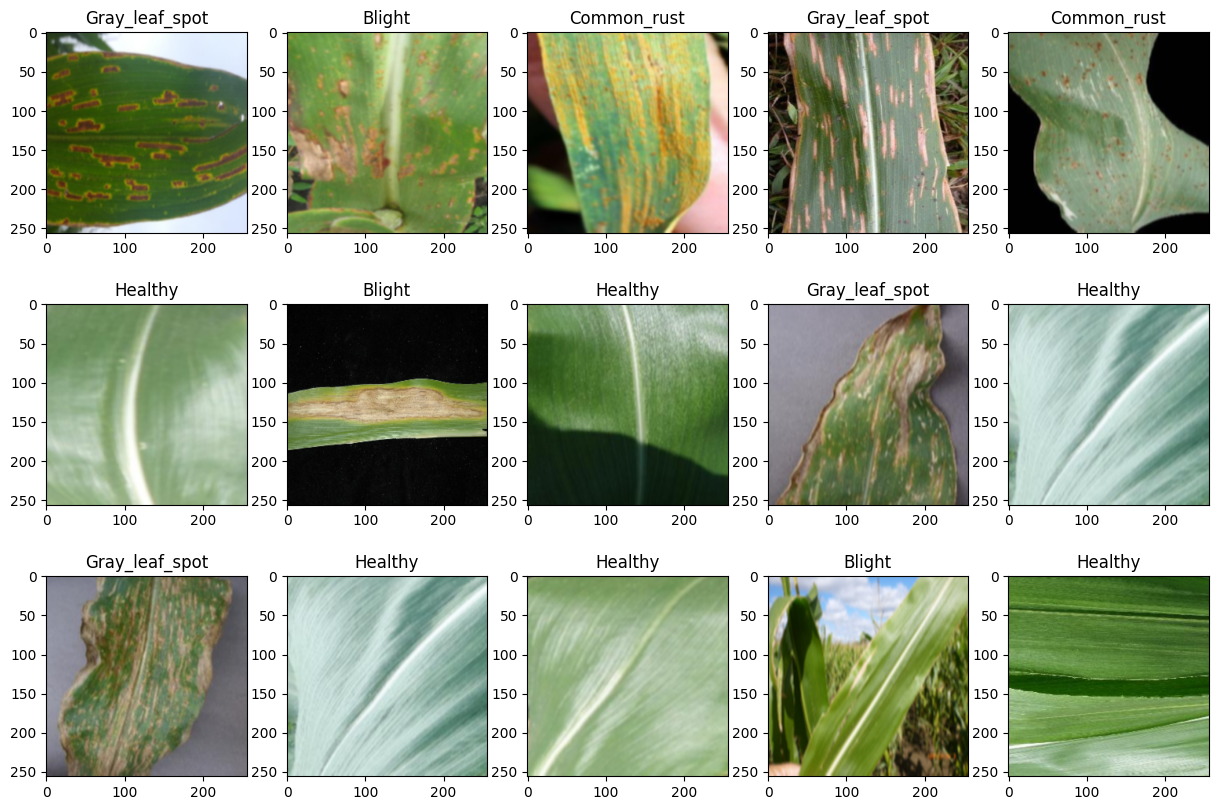

In [9]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample_index = random.randint(0, len(image_files))
    img_path = image_files[sample_index]
    img = preprocess_image(img_path)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].title.set_text(labels[sample_index])

plt.show()

In [25]:
data = pd.DataFrame({"image_path": image_files, "label": labels})

# Membagi data menjadi data latih dan data validasi
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Augmentasi gambar menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator()

batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 333 validated image filenames belonging to 4 classes.
Found 84 validated image filenames belonging to 4 classes.


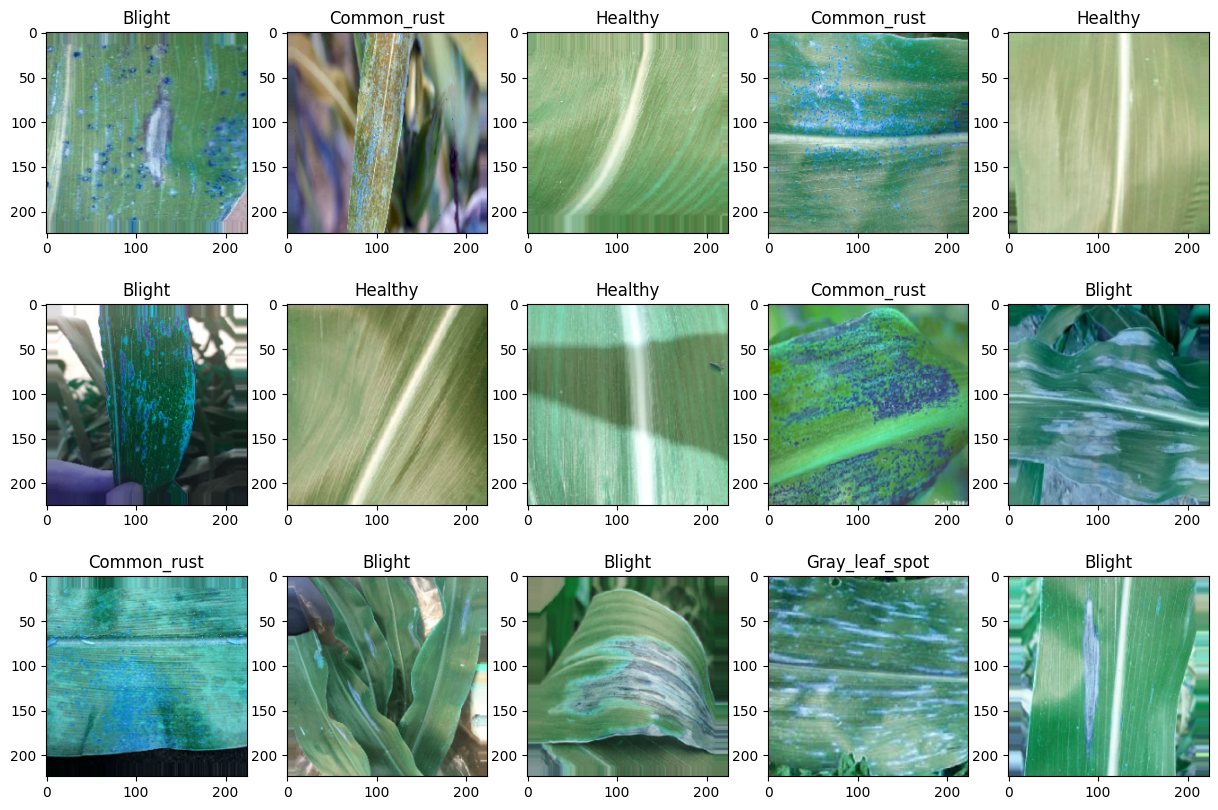

In [26]:
class_labels = list(train_generator.class_indices.keys())

# Visualisasi gambar-gambar setelah augmentasi
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    batch = train_generator.next()
    img = batch[0][0].astype(np.uint8)
    label_index = np.argmax(batch[1][0])  # Mendapatkan indeks label kelas dengan nilai tertinggi
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].title.set_text(class_labels[label_index])  # Menampilkan label kelas

plt.show()

In [27]:
num_classes = len(set(labels))
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
11/11 [==============================] - 13s 881ms/step - loss: 2.0553 - accuracy: 0.5315 - val_loss: 1.1600 - val_accuracy: 0.7143
Epoch 2/10
11/11 [==============================] - 9s 807ms/step - loss: 0.6464 - accuracy: 0.7958 - val_loss: 0.7649 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 7s 680ms/step - loss: 0.4379 - accuracy: 0.8408 - val_loss: 0.5669 - val_accuracy: 0.7619
Epoch 4/10
11/11 [==============================] - 9s 765ms/step - loss: 0.3322 - accuracy: 0.8859 - val_loss: 0.7776 - val_accuracy: 0.7619
Epoch 5/10
11/11 [==============================] - 9s 757ms/step - loss: 0.2093 - accuracy: 0.9189 - val_loss: 0.6042 - val_accuracy: 0.7619
Epoch 6/10
11/11 [==============================] - 8s 725ms/step - loss: 0.1584 - accuracy: 0.9459 - val_loss: 0.5301 - val_accuracy: 0.7738
Epoch 7/10
11/11 [==============================] - 8s 745ms/step - loss: 0.1184 - accuracy: 0.9580 - val_loss: 0.4295 - val_accuracy: 0.8095
Epoch

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

# Mendapatkan prediksi dari data validasi
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Mendapatkan label sebenarnya dari data validasi
y_val_true = val_generator.classes

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Membuat classification report
class_names = list(val_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_val_true, y_val_pred_classes, target_names=class_names))

3/3 [==============================] - 3s 767ms/step
Confusion Matrix:
[[ 2  5  1  6]
 [ 7 18  2  7]
 [ 6  6  2  3]
 [ 5  7  4  3]]
Classification Report:
                precision    recall  f1-score   support

        Blight       0.10      0.14      0.12        14
   Common_rust       0.50      0.53      0.51        34
Gray_leaf_spot       0.22      0.12      0.15        17
       Healthy       0.16      0.16      0.16        19

      accuracy                           0.30        84
     macro avg       0.25      0.24      0.24        84
  weighted avg       0.30      0.30      0.29        84

